In [1]:
!pip install "dask[complete]"

In [5]:
from dask.distributed import Client
import dask.dataframe as dd

# 1. SHUTDOWN any existing clients to free up ports and memory
try:
    client.close()
except:
    pass

# 2. INITIALIZE Client with n_workers=1
# This consolidates all 1.73 GB of RAM into a single worker process.
# threads_per_worker=4 allows it to still use multiple cores for computation.
client = Client(n_workers=1, threads_per_worker=4)

print("New Client Configuration:")
print(client)

2025-12-05 12:59:10,693 - distributed.nanny - WARNING - Worker process still alive after 3.199784851074219 seconds, killing
2025-12-05 12:59:11,040 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing
2025-12-05 12:59:11,066 - distributed.nanny - WARNING - Worker process still alive after 3.1999981689453127 seconds, killing


New Client Configuration:
<Client: 'tcp://127.0.0.1:42181' processes=1 threads=4, memory=1.73 GiB>


In [6]:
# 3. Read the Parquet file
filename = "yellow_tripdata_2024-01.parquet"

# Optimization: If you don't need all columns, specify them to save RAM.
# Uncomment the line below to test with fewer columns if it still crashes.
# columns_to_keep = ['tpep_pickup_datetime', 'passenger_count', 'total_amount']
# ddf = dd.read_parquet(filename, columns=columns_to_keep)

ddf = dd.read_parquet(filename)

# 4. Check the head
print("Loading head...")
print(ddf.head())

Loading head...
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            79           211   
4           0.80         1.0                  N           211           148   

   payment_type  fare_amount  extra  mta_tax  tip_amount  

In [7]:
# 1. Check the data types
# It is crucial that 'tpep_pickup_datetime' is a datetime type, not 'object' (string).
print("--- Column Data Types ---")
print(ddf.dtypes)

# 2. Count the total rows
# Since Dask is lazy, we need to ask it to count. This might take a moment.
print("\n--- Counting Total Rows ---")
row_count = len(ddf)
print(f"Total number of taxi trips: {row_count}")

# 3. Check for missing values (NaN)
# This computes the sum of nulls for each column
print("\n--- Checking for Missing Values ---")
missing_values = ddf.isnull().sum().compute()
print(missing_values)

--- Column Data Types ---
VendorID                           int32
tpep_pickup_datetime      datetime64[us]
tpep_dropoff_datetime     datetime64[us]
passenger_count                    int64
trip_distance                    float64
RatecodeID                         int64
store_and_fwd_flag       string[pyarrow]
PULocationID                       int32
DOLocationID                       int32
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
congestion_surcharge             float64
Airport_fee                      float64
dtype: object

--- Counting Total Rows ---
Total number of taxi trips: 2964624

--- Checking for Missing Values ---
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_da

In [8]:
# 1. Drop rows with missing values
# removing ~140k rows (5%) to ensure clean data for the model
ddf_clean = ddf.dropna(subset=['passenger_count', 'RatecodeID'])

# 2. Filter out "Bad Data" (Negative fares, 0 distance)
# Sometimes the data contains refunds or system errors
ddf_clean = ddf_clean[
    (ddf_clean['fare_amount'] > 0) &
    (ddf_clean['trip_distance'] > 0)
]

# 3. Create a 'trip_duration' column (in minutes)
# Calculate the difference between dropoff and pickup
ddf_clean['trip_duration'] = (
    ddf_clean['tpep_dropoff_datetime'] - ddf_clean['tpep_pickup_datetime']
).dt.total_seconds() / 60

# 4. Filter unrealistic durations
# Keep trips between 1 minute and 3 hours (180 mins)
ddf_clean = ddf_clean[
    (ddf_clean['trip_duration'] >= 1) & 
    (ddf_clean['trip_duration'] <= 180)
]

# 5. Extract "Hour" and "Day" (Crucial for predicting rush hour fares)
ddf_clean['pickup_hour'] = ddf_clean['tpep_pickup_datetime'].dt.hour
ddf_clean['pickup_day'] = ddf_clean['tpep_pickup_datetime'].dt.dayofweek

print("Cleaning and Feature Engineering setup complete.")
print("Preview of new features:")
print(ddf_clean[['trip_duration', 'pickup_hour', 'fare_amount']].head())

Cleaning and Feature Engineering setup complete.
Preview of new features:
   trip_duration  pickup_hour  fare_amount
0      19.800000            0         17.7
1       6.600000            0         10.0
2      17.916667            0         23.3
3       8.300000            0         10.0
4       6.100000            0          7.9


In [9]:
# 1. Define your Festival/Holiday dates (for Jan 2024)

festival_days = [1, 15]  # Jan 1st (New Year), Jan 15th (MLK Day)

# 2. Create a binary column: 1 if it's a festival, 0 if not

ddf_clean['is_festival'] = ddf_clean['tpep_pickup_datetime'].dt.day.isin(festival_days).astype(int)

# 3. Analyze the impact of Festivals
# We group by 'is_festival' to see the difference in Volume and Duration
print("Calculating Festival stats... (This might take a minute)")

festival_stats = ddf_clean.groupby('is_festival').agg({
    'fare_amount': ['count', 'mean'],     # Count = "How many fares" (Volume), Mean = Avg Cost
    'trip_duration': 'mean'               # Mean = Avg Duration
}).compute()

# Rename columns for clarity
festival_stats.columns = ['Total_Trips', 'Avg_Fare_Amount', 'Avg_Trip_Duration']
print(festival_stats)

Calculating Festival stats... (This might take a minute)
             Total_Trips  Avg_Fare_Amount  Avg_Trip_Duration
is_festival                                                 
1                 139684        20.674909          14.715816
0                2604298        18.249600          14.966055


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore') # Hides sklearn warnings for cleaner output

# 1. Prepare the Data for Training
# Sampling 10% to keep memory usage safe
print("Sampling data for training...")
df_sample = ddf_clean.sample(frac=0.1, random_state=42).compute()

# Features used for prediction
X = df_sample[['is_festival', 'trip_distance', 'pickup_hour']]

# Targets: We now train on THREE targets
y_fare = df_sample['fare_amount']       # Base Meter Charge
y_duration = df_sample['trip_duration'] # Time in minutes
y_price = df_sample['total_amount']     # Final Total Price (incl. taxes/fees)

# 2. Train The Models
print("Training prediction models...")

# Model A: Fare (Meter)
model_fare = LinearRegression()
model_fare.fit(X, y_fare)

# Model B: Duration (Time)
model_duration = LinearRegression()
model_duration.fit(X, y_duration)

# Model C: Total Price (Final Cost)
model_price = LinearRegression()
model_price.fit(X, y_price)

print("Training Complete!")

# 3. Create the Enhanced Prediction Function
def predict_trip_details(is_festival, miles, hour):
    # Prepare input: [is_festival, distance, hour]
    input_data = [[is_festival, miles, hour]]
    
    # Make predictions
    pred_fare = model_fare.predict(input_data)[0]
    pred_time = model_duration.predict(input_data)[0]
    pred_total = model_price.predict(input_data)[0]
    
    day_type = "FESTIVAL DAY (Holiday)" if is_festival == 1 else "NORMAL DAY"
    
    print(f"--- Prediction for {day_type} ---")
    print(f"Trip Specs:         {miles} miles at {hour}:00")
    print(f"Predicted Duration: {pred_time:.1f} minutes")
    print(f"Base Fare (Meter):  ${pred_fare:.2f}")
    print(f"ESTIMATED TOTAL:    ${pred_total:.2f} (Final Price)")
    print("-----------------------------------")

# 4. Test: Compare Normal vs Festival
# Example: A 5-mile trip at 6 PM (18:00)
predict_trip_details(is_festival=0, miles=5, hour=18) # Normal
predict_trip_details(is_festival=1, miles=5, hour=18) # Festival

Sampling data for training...
Training prediction models...
Training Complete!
--- Prediction for NORMAL DAY ---
Trip Specs:         5 miles at 18:00
Predicted Duration: 18.6 minutes
Base Fare (Meter):  $24.66
ESTIMATED TOTAL:    $35.61 (Final Price)
-----------------------------------
--- Prediction for FESTIVAL DAY (Holiday) ---
Trip Specs:         5 miles at 18:00
Predicted Duration: 16.7 minutes
Base Fare (Meter):  $24.08
ESTIMATED TOTAL:    $34.58 (Final Price)
-----------------------------------


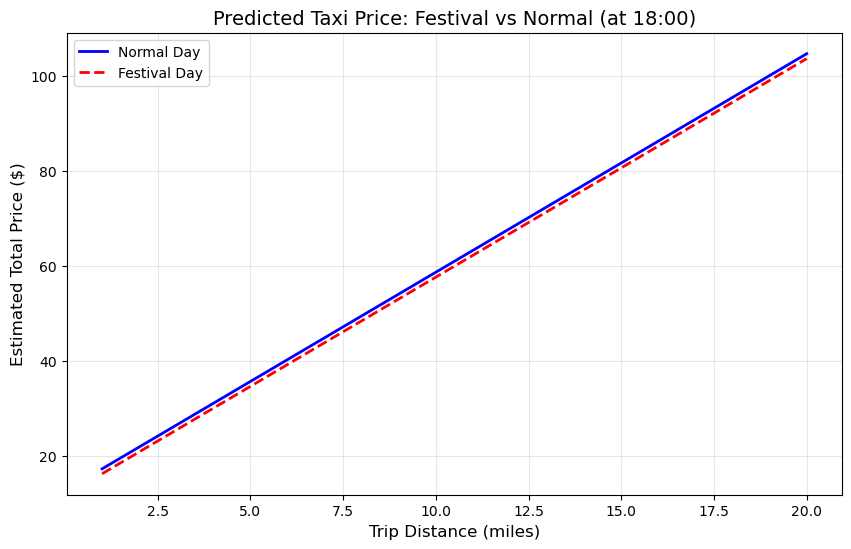

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Create a range of distances to test (1 to 20 miles)
distances = np.linspace(1, 20, 50)
hour = 18  # Fixed at 6 PM

# 2. Predict prices for both scenarios
normal_prices = [model_price.predict([[0, dist, hour]])[0] for dist in distances]
festival_prices = [model_price.predict([[1, dist, hour]])[0] for dist in distances]

# 3. Plot the comparison
plt.figure(figsize=(10, 6))
plt.plot(distances, normal_prices, label='Normal Day', color='blue', linewidth=2)
plt.plot(distances, festival_prices, label='Festival Day', color='red', linestyle='--', linewidth=2)

plt.title(f'Predicted Taxi Price: Festival vs Normal (at {hour}:00)', fontsize=14)
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Estimated Total Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Show the graph
plt.show()

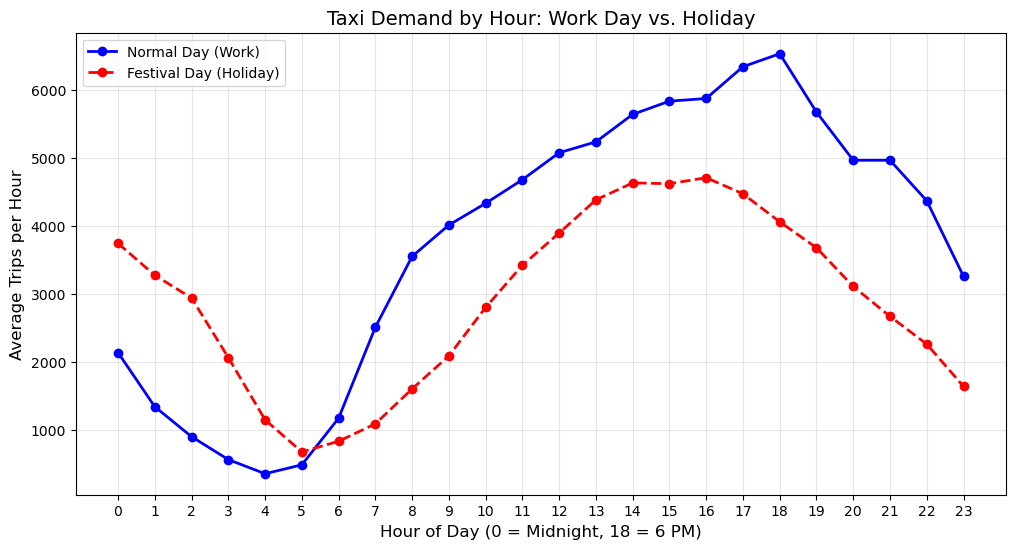

In [12]:
# 1. Group by Hour and Festival Status
hourly_demand = ddf_clean.groupby(['pickup_hour', 'is_festival'])['fare_amount'].count().compute()

# 2. Reshape for plotting
# This organizes the data so we have columns for "Normal" and "Festival"
demand_df = hourly_demand.unstack(level=1)
demand_df.columns = ['Normal Day', 'Festival Day']

# 3. Normalize the data
# Since we have 29 Normal days and only 2 Festival days, we must average them
# to make a fair comparison.
demand_df['Normal Day'] = demand_df['Normal Day'] / 29
demand_df['Festival Day'] = demand_df['Festival Day'] / 2

# 4. Plot the Hourly Trends
plt.figure(figsize=(12, 6))

# Plot Normal Days (Blue)
plt.plot(demand_df.index, demand_df['Normal Day'], label='Normal Day (Work)', 
         color='blue', marker='o', linewidth=2)

# Plot Festival Days (Red)
plt.plot(demand_df.index, demand_df['Festival Day'], label='Festival Day (Holiday)', 
         color='red', marker='o', linestyle='--', linewidth=2)

plt.title('Taxi Demand by Hour: Work Day vs. Holiday', fontsize=14)
plt.xlabel('Hour of Day (0 = Midnight, 18 = 6 PM)', fontsize=12)
plt.ylabel('Average Trips per Hour', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [14]:
content = "*.parquet\n"

with open(".gitignore", "w") as f:
    f.write(content)

print("Success! .gitignore file created.")

Success! .gitignore file created.


In [15]:
import os

if ".gitignore" in os.listdir():
    print("Found it! The .gitignore file exists.")
else:
    print("Something went wrong.")

Found it! The .gitignore file exists.
